In [1]:
import random
import pandas as pd
import numpy as np
from tqdm import tqdm
import sqlite3
from matplotlib import pyplot as plt
from datetime import datetime, timedelta
from collections import defaultdict
import seaborn as sns

In [2]:
#pull in data
con = sqlite3.connect('nba.db')

team_basic_boxscores_df = pd.read_sql('select * from team_basic_boxscores', con)
team_advanced_boxscores_df = pd.read_sql('select * from team_advanced_boxscores', con)

team_boxscores_df = team_basic_boxscores_df.merge(team_advanced_boxscores_df, how='inner', on=['GAME_ID', 'TEAM_ID'])

pd.set_option('display.max_columns', None)
team_boxscores_df.head()

,SEASON,TEAM_ID,TEAM_ABBREVIATION_x,TEAM_NAME_x,GAME_ID,GAME_DATE,MATCHUP,WL,MIN_x,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,TEAM_NAME_y,TEAM_ABBREVIATION_y,TEAM_CITY,MIN_y,E_OFF_RATING,OFF_RATING,E_DEF_RATING,DEF_RATING,E_NET_RATING,NET_RATING,AST_PCT,AST_TOV,AST_RATIO,OREB_PCT,DREB_PCT,REB_PCT,E_TM_TOV_PCT,TM_TOV_PCT,EFG_PCT,TS_PCT,USG_PCT,E_USG_PCT,E_PACE,PACE,PACE_PER40,POSS,PIE
0,2021-22,1610612747,LAL,Los Angeles Lakers,0022100002,2021-10-19,LAL vs. GSW,L,240,45,95,0.474,15,42,0.357,9,19,0.474,5,40,45,21,7,4,18,25,114,-7,Lakers,LAL,Los Angeles,240:00,98.0,101.8,106.0,107.1,-8.0,-5.3,0.467,1.17,14.8,0.189,0.759,0.477,15.469,16.1,0.553,0.551,1.0,0.198,115.28,112.5,93.75,112.0,0.422
1,2021-22,1610612744,GSW,Golden State Warriors,0022100002,2021-10-19,GSW @ LAL,W,240,41,93,0.441,14,39,0.359,25,30,0.833,9,41,50,30,9,2,17,18,121,7,Warriors,GSW,Golden State,240:00,106.0,107.1,98.0,101.8,8.0,5.3,0.732,1.76,19.6,0.241,0.811,0.523,14.886,15.0,0.516,0.570,1.0,0.200,115.28,112.5,93.75,113.0,0.578
2,2021-22,1610612751,BKN,Brooklyn Nets,0022100001,2021-10-19,BKN @ MIL,L,240,37,84,0.440,17,32,0.531,13,23,0.565,5,39,44,19,3,9,13,17,104,-23,Nets,BKN,Brooklyn,240:00,101.8,102.0,117.7,124.5,-15.8,-22.5,0.514,1.46,15.1,0.176,0.707,0.459,12.730,12.7,0.542,0.552,1.0,0.200,105.02,102.0,85.00,102.0,0.407
3,2021-22,1610612749,MIL,Milwaukee Bucks,0022100001,2021-10-19,MIL vs. BKN,W,240,48,105,0.457,17,45,0.378,14,18,0.778,13,41,54,25,8,9,8,19,127,23,Bucks,MIL,Milwaukee,240:00,117.7,124.5,101.8,102.0,15.8,22.5,0.521,3.13,17.1,0.293,0.824,0.541,7.413,7.8,0.538,0.562,1.0,0.194,105.02,102.0,85.00,102.0,0.593
4,2021-22,1610612754,IND,Indiana Pacers,0022100003,2021-10-20,IND @ CHA,L,240,42,90,0.467,17,47,0.362,21,24,0.875,8,43,51,29,2,10,17,24,122,-1,Pacers,IND,Indiana,240:00,111.4,114.0,107.1,116.0,4.3,-2.0,0.690,1.71,19.8,0.255,0.667,0.487,15.517,15.9,0.561,0.607,1.0,0.199,112.22,106.5,88.75,107.0,0.520


In [3]:
team_boxscores_df.drop(columns=['TEAM_NAME_y', 'TEAM_ABBREVIATION_y', 'MIN_y'], inplace=True)
team_boxscores_df.rename(columns={'TEAM_ABBREVIATION_x':'TEAM_ABBREVIATION', 'TEAM_NAME_x':'TEAM_NAME', 'MIN_x':'MIN'}, inplace=True)
team_boxscores_df.columns

Index(['SEASON', 'TEAM_ID', 'TEAM_ABBREVIATION', 'TEAM_NAME', 'GAME_ID',
       'GAME_DATE', 'MATCHUP', 'WL', 'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M',
       'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST',
       'STL', 'BLK', 'TOV', 'PF', 'PTS', 'PLUS_MINUS', 'TEAM_CITY',
       'E_OFF_RATING', 'OFF_RATING', 'E_DEF_RATING', 'DEF_RATING',
       'E_NET_RATING', 'NET_RATING', 'AST_PCT', 'AST_TOV', 'AST_RATIO',
       'OREB_PCT', 'DREB_PCT', 'REB_PCT', 'E_TM_TOV_PCT', 'TM_TOV_PCT',
       'EFG_PCT', 'TS_PCT', 'USG_PCT', 'E_USG_PCT', 'E_PACE', 'PACE',
       'PACE_PER40', 'POSS', 'PIE'],
      dtype='object')

In [4]:
#add home team flag
team_boxscores_df['HOME_TEAM'] = team_boxscores_df['MATCHUP'].str[4] == 'v'
team_boxscores_df['HOME_TEAM']

0         True
1        False
2        False
3         True
4        False
         ...  
56299    False
56300    False
56301     True
56302    False
56303     True
Name: HOME_TEAM, Length: 56304, dtype: bool

In [5]:
#reformat so each game is represented by a single row
home_team_boxscores_df = team_boxscores_df[team_boxscores_df['HOME_TEAM']==True]
away_team_boxscores_df = team_boxscores_df[team_boxscores_df['HOME_TEAM']==False]

team_boxscores_df = home_team_boxscores_df.merge(away_team_boxscores_df, how='inner', on='GAME_ID', suffixes=('_HOME', '_AWAY'))

In [6]:
#remove redundant/unnecessary columns
team_boxscores_df.rename(columns={'SEASON_HOME':'SEASON',
                                  'GAME_DATE_HOME':'GAME_DATE',
                                  'MATCHUP_AWAY':'MATCHUP',}, inplace=True)
team_boxscores_df.drop(columns=['SEASON_AWAY',
                                'GAME_DATE_AWAY',
                                'MATCHUP_HOME',
                                'TEAM_ABBREVIATION_HOME',
                                'TEAM_ABBREVIATION_AWAY',
                                'TEAM_NAME_HOME',
                                'TEAM_NAME_AWAY',
                                'MIN_HOME',
                                'MIN_AWAY',
                                'HOME_TEAM_HOME',
                                'HOME_TEAM_AWAY',
                                'MATCHUP'], inplace=True)
#sort by game date
team_boxscores_df['GAME_DATE'] = pd.to_datetime(team_boxscores_df['GAME_DATE'], format='%Y/%m/%d')
team_boxscores_df.sort_values(by='GAME_DATE', ascending=False, inplace=True)

team_boxscores_df.head()

,SEASON,TEAM_ID_HOME,GAME_ID,GAME_DATE,WL_HOME,FGM_HOME,FGA_HOME,FG_PCT_HOME,FG3M_HOME,FG3A_HOME,FG3_PCT_HOME,FTM_HOME,FTA_HOME,FT_PCT_HOME,OREB_HOME,DREB_HOME,REB_HOME,AST_HOME,STL_HOME,BLK_HOME,TOV_HOME,PF_HOME,PTS_HOME,PLUS_MINUS_HOME,TEAM_CITY_HOME,E_OFF_RATING_HOME,OFF_RATING_HOME,E_DEF_RATING_HOME,DEF_RATING_HOME,E_NET_RATING_HOME,NET_RATING_HOME,AST_PCT_HOME,AST_TOV_HOME,AST_RATIO_HOME,OREB_PCT_HOME,DREB_PCT_HOME,REB_PCT_HOME,E_TM_TOV_PCT_HOME,TM_TOV_PCT_HOME,EFG_PCT_HOME,TS_PCT_HOME,USG_PCT_HOME,E_USG_PCT_HOME,E_PACE_HOME,PACE_HOME,PACE_PER40_HOME,POSS_HOME,PIE_HOME,TEAM_ID_AWAY,WL_AWAY,FGM_AWAY,FGA_AWAY,FG_PCT_AWAY,FG3M_AWAY,FG3A_AWAY,FG3_PCT_AWAY,FTM_AWAY,FTA_AWAY,FT_PCT_AWAY,OREB_AWAY,DREB_AWAY,REB_AWAY,AST_AWAY,STL_AWAY,BLK_AWAY,TOV_AWAY,PF_AWAY,PTS_AWAY,PLUS_MINUS_AWAY,TEAM_CITY_AWAY,E_OFF_RATING_AWAY,OFF_RATING_AWAY,E_DEF_RATING_AWAY,DEF_RATING_AWAY,E_NET_RATING_AWAY,NET_RATING_AWAY,AST_PCT_AWAY,AST_TOV_AWAY,AST_RATIO_AWAY,OREB_PCT_AWAY,DREB_PCT_AWAY,REB_PCT_AWAY,E_TM_TOV_PCT_AWAY,TM_TOV_PCT_AWAY,EFG_PCT_AWAY,TS_PCT_AWAY,USG_PCT_AWAY,E_USG_PCT_AWAY,E_PACE_AWAY,PACE_AWAY,PACE_PER40_AWAY,POSS_AWAY,PIE_AWAY
1314,2021-22,1610612738,0042100404,2022-06-10,L,34,85,0.400,15,38,0.395,14,19,0.737,11,31,42,22,8,6,16,17,97,-10,Boston,98.6,101.0,109.6,111.5,-11.0,-10.4,0.647,1.38,16.7,0.264,0.615,0.438,16.267,16.7,0.488,0.519,1.0,0.196,97.98,96.0,80.00,96.0,0.448,1610612744,W,40,91,0.440,15,43,0.349,12,15,0.800,16,39,55,20,10,5,16,21,107,10,Golden State,109.6,111.5,98.6,101.0,11.0,10.4,0.500,1.25,15.0,0.385,0.736,0.562,16.393,16.7,0.522,0.548,1.0,0.201,97.98,96.0,80.00,96.0,0.552
1313,2021-22,1610612738,0042100403,2022-06-08,W,43,89,0.483,13,35,0.371,17,24,0.708,15,32,47,28,7,7,12,17,116,16,Boston,120.1,122.1,104.6,106.4,15.5,15.7,0.651,2.33,20.1,0.408,0.810,0.593,12.428,12.6,0.556,0.583,1.0,0.201,96.08,94.5,78.75,95.0,0.597,1610612744,L,36,78,0.462,15,40,0.375,13,15,0.867,6,25,31,22,7,5,17,23,100,-16,Golden State,104.6,106.4,120.1,122.1,-15.5,-15.7,0.611,1.29,17.8,0.190,0.592,0.407,17.782,18.1,0.558,0.591,1.0,0.199,96.08,94.5,78.75,94.0,0.403
1312,2021-22,1610612744,0042100402,2022-06-05,W,39,86,0.453,15,37,0.405,14,20,0.700,6,36,42,25,15,2,12,17,107,19,Golden State,106.2,110.3,87.6,89.8,18.6,20.5,0.641,2.08,19.0,0.224,0.780,0.505,11.905,12.4,0.541,0.564,1.0,0.200,100.64,97.5,81.25,97.0,0.602,1610612738,L,30,80,0.375,15,37,0.405,13,17,0.765,6,37,43,24,5,7,19,18,88,-19,Boston,87.6,89.8,106.2,110.3,-18.6,-20.5,0.800,1.26,18.4,0.220,0.776,0.495,18.909,19.4,0.469,0.503,1.0,0.197,100.64,97.5,81.25,98.0,0.398
1311,2021-22,1610612744,0042100401,2022-06-02,L,39,88,0.443,19,45,0.422,11,15,0.733,12,27,39,24,8,6,14,16,108,-12,Golden State,111.8,114.9,122.4,129.0,-10.6,-14.1,0.615,1.71,18.1,0.353,0.698,0.511,14.493,14.9,0.551,0.571,1.0,0.201,97.32,93.5,77.92,94.0,0.422,1610612738,W,43,85,0.506,21,41,0.512,13,16,0.813,7,32,39,33,7,6,13,13,120,12,Boston,122.4,129.0,111.8,114.9,10.6,14.1,0.767,2.54,23.9,0.302,0.647,0.489,13.260,14.0,0.629,0.652,1.0,0.198,97.32,93.5,77.92,93.0,0.578
1310,2021-22,1610612748,0042100307,2022-05-29,L,37,88,0.420,6,30,0.200,16,24,0.667,7,37,44,16,4,5,10,18,96,-4,Miami,94.5,99.0,101.5,103.1,-6.9,-4.1,0.432,1.60,12.8,0.214,0.741,0.473,9.846,10.3,0.455,0.487,1.0,0.193,100.06,97.0,80.83,97.0,0.471,1610612738,W,35,85,0.412,11,32,0.344,19,24,0.792,10,41,51,22,4,6,13,26,100,4,Boston,101.5,103.1,94.5,99.0,6.9,4.1,0.629,1.69,16.9,0.259,0.786,0.527,13.190,13.4,0.476,0.523,1.0,0.201,100.06,97.0,80.83,97.0,0.529


In [7]:
team_boxscores_df.describe()

,TEAM_ID_HOME,FGM_HOME,FGA_HOME,FG_PCT_HOME,FG3M_HOME,FG3A_HOME,FG3_PCT_HOME,FTM_HOME,FTA_HOME,FT_PCT_HOME,OREB_HOME,DREB_HOME,REB_HOME,AST_HOME,STL_HOME,BLK_HOME,TOV_HOME,PF_HOME,PTS_HOME,PLUS_MINUS_HOME,E_OFF_RATING_HOME,OFF_RATING_HOME,E_DEF_RATING_HOME,DEF_RATING_HOME,E_NET_RATING_HOME,NET_RATING_HOME,AST_PCT_HOME,AST_TOV_HOME,AST_RATIO_HOME,OREB_PCT_HOME,DREB_PCT_HOME,REB_PCT_HOME,E_TM_TOV_PCT_HOME,TM_TOV_PCT_HOME,EFG_PCT_HOME,TS_PCT_HOME,USG_PCT_HOME,E_USG_PCT_HOME,E_PACE_HOME,PACE_HOME,PACE_PER40_HOME,POSS_HOME,PIE_HOME,TEAM_ID_AWAY,FGM_AWAY,FGA_AWAY,FG_PCT_AWAY,FG3M_AWAY,FG3A_AWAY,FG3_PCT_AWAY,FTM_AWAY,FTA_AWAY,FT_PCT_AWAY,OREB_AWAY,DREB_AWAY,REB_AWAY,AST_AWAY,STL_AWAY,BLK_AWAY,TOV_AWAY,PF_AWAY,PTS_AWAY,PLUS_MINUS_AWAY,E_OFF_RATING_AWAY,OFF_RATING_AWAY,E_DEF_RATING_AWAY,DEF_RATING_AWAY,E_NET_RATING_AWAY,NET_RATING_AWAY,AST_PCT_AWAY,AST_TOV_AWAY,AST_RATIO_AWAY,OREB_PCT_AWAY,DREB_PCT_AWAY,REB_PCT_AWAY,E_TM_TOV_PCT_AWAY,TM_TOV_PCT_AWAY,EFG_PCT_AWAY,TS_PCT_AWAY,USG_PCT_AWAY,E_USG_PCT_AWAY,E_PACE_AWAY,PACE_AWAY,PACE_PER40_AWAY,POSS_AWAY,PIE_AWAY
count,2.815200e+04,28152.000000,28152.000000,28152.000000,28152.000000,28152.000000,28152.000000,28152.000000,28152.000000,28152.000000,28152.000000,28152.000000,28152.000000,28152.000000,28152.000000,28152.00000,28152.000000,28152.000000,28152.000000,28152.000000,28152.000000,28152.000000,28152.000000,28152.000000,28152.000000,28152.000000,28152.000000,28152.000000,28152.000000,24862.000000,25048.000000,22231.000000,28152.000000,28152.000000,28152.000000,28152.000000,28152.0,28152.000000,28152.000000,28152.000000,28152.000000,28152.000000,28152.000000,2.815200e+04,28152.000000,28152.000000,28152.000000,28152.000000,28152.000000,28152.000000,28152.000000,28152.000000,28152.000000,28152.000000,28152.000000,28152.000000,28152.000000,28152.000000,28152.000000,28152.000000,28152.000000,28152.000000,28152.000000,28152.000000,28152.000000,28152.000000,28152.000000,28152.000000,28152.000000,28152.000000,28152.000000,28152.000000,25041.000000,24864.000000,22226.000000,28152.000000,28152.000000,28152.000000,28152.000000,28152.0,28152.000000,28152.000000,28152.000000,28152.000000,28152.000000,28152.000000
mean,1.610613e+09,38.082090,82.925760,0.460175,7.812802,21.706238,0.356823,18.544473,24.401570,0.760776,11.137504,32.171036,43.308539,22.799304,7.596689,5.15324,14.191851,20.636544,102.521455,2.933646,105.992448,107.538658,102.821483,104.507797,3.171267,3.031074,0.597975,1.758120,17.353243,0.298946,0.711452,0.506694,14.666462,14.888402,0.506982,0.548106,1.0,0.198531,96.071494,94.567980,78.806643,95.285237,0.523338,1.610613e+09,37.096192,82.837312,0.448633,7.656934,21.687837,0.349351,17.738491,23.392974,0.758871,10.813015,31.174339,41.987354,21.370986,7.530193,4.627096,14.518507,21.298345,99.587809,-2.933646,102.821483,104.507797,105.992448,107.538658,-3.171267,-3.031074,0.575326,1.613086,16.462383,0.288536,0.701079,0.493297,14.992494,15.248206,0.494562,0.535315,1.0,0.198464,96.071504,94.567989,78.806650,95.232026,0.476666
std,8.617925e+00,5.413436,7.922345,0.056681,4.113602,9.261323,0.115518,6.319286,7.813606,0.100173,4.006765,5.494002,6.598403,5.188857,2.924085,2.65647,3.886643,4.367757,13.208096,13.380847,11.446642,11.347108,11.620512,11.537321,14.537839,13.994258,0.102314,0.761994,3.252078,0.074943,0.073955,0.048570,3.867306,3.941046,0.067383,0.062072,0.0,0.002295,5.909511,5.768287,4.806883,6.371492,0.097206,8.618508e+00,5.357138,7.950226,0.055405,4.062750,9.229117,0.113405,6.079245,7.470148,0.103284,3.917608,5.464286,6.494499,5.120589,2.884540,2.446364,3.984189,4.561607,13.346979,13.380847,11.620512,11.537321,11.446642,11.347108,14.537839,13.994258,0.106059,0.699735,3.271408,0.073953,0.074944,0.048574,3.991820,4.077823,0.066478,0.061930,0.0,0.002324,5.909472,5.768244,4.806847,6.370156,0.097207
min,1.610613e+09,17.000000,51.000000,0.247000,0.000000,1.000000,0.000000,1.000000,1.000000,0.143000,1.000000,13.000000,17.000000,6.000000,0.000000,0.00000,1.000000,6.000000,56.000000,-58.000000,62.

In [8]:
#look into missing rebound percentage stats
#calculate rebound percentage stats
team_boxscores_df['OREB_PCT_HOME_CALC'] = team_boxscores_df['OREB_HOME'] / (team_boxscores_df['OREB_HOME'] + team_boxscores_df['DREB_AWAY'])
team_boxscores_df['DREB_PCT_HOME_CALC'] = team_boxscores_df['DREB_HOME'] / (team_boxscores_df['DREB_HOME'] + team_boxscores_df['OREB_AWAY'])
team_boxscores_df['REB_PCT_HOME_CALC'] = team_boxscores_df['REB_HOME'] / (team_boxscores_df['REB_HOME'] + team_boxscores_df['REB_AWAY'])
team_boxscores_df['OREB_PCT_AWAY_CALC'] = team_boxscores_df['OREB_AWAY'] / (team_boxscores_df['OREB_AWAY'] + team_boxscores_df['DREB_HOME'])
team_boxscores_df['DREB_PCT_AWAY_CALC'] = team_boxscores_df['DREB_AWAY'] / (team_boxscores_df['DREB_AWAY'] + team_boxscores_df['OREB_HOME'])
team_boxscores_df['REB_PCT_AWAY_CALC'] = team_boxscores_df['REB_AWAY'] / (team_boxscores_df['REB_AWAY'] + team_boxscores_df['REB_HOME'])

#calculate error of calculated stats
team_boxscores_df['OREB_PCT_CALC_HOME_DIFF'] = team_boxscores_df['OREB_PCT_HOME'] - team_boxscores_df['OREB_PCT_HOME_CALC']
team_boxscores_df['DREB_PCT_CALC_HOME_DIFF'] = team_boxscores_df['DREB_PCT_HOME'] - team_boxscores_df['DREB_PCT_HOME_CALC']
team_boxscores_df['REB_PCT_CALC_HOME_DIFF'] = team_boxscores_df['REB_PCT_HOME'] - team_boxscores_df['REB_PCT_HOME_CALC']
team_boxscores_df['OREB_PCT_CALC_AWAY_DIFF'] = team_boxscores_df['OREB_PCT_AWAY'] - team_boxscores_df['OREB_PCT_AWAY_CALC']
team_boxscores_df['DREB_PCT_CALC_AWAY_DIFF'] = team_boxscores_df['DREB_PCT_AWAY'] - team_boxscores_df['DREB_PCT_AWAY_CALC']
team_boxscores_df['REB_PCT_CALC_AWAY_DIFF'] = team_boxscores_df['REB_PCT_AWAY'] - team_boxscores_df['REB_PCT_AWAY_CALC']


Text(0, 0.5, 'count')

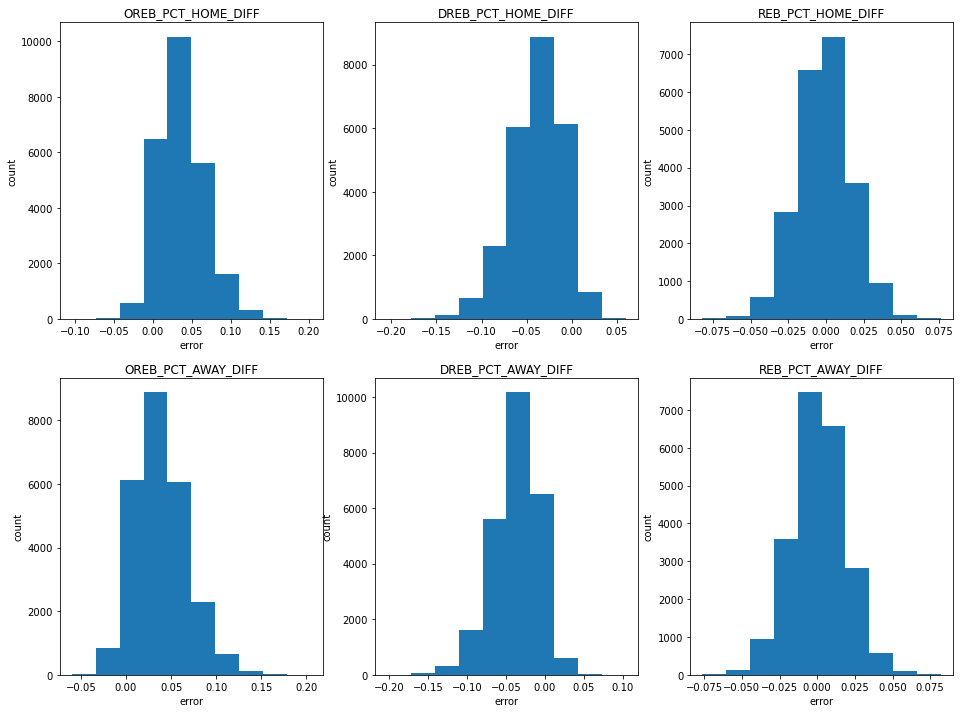

In [9]:
#plot error of calculated rebound percentage stats
fig, axes = plt.subplots(2, 3, figsize=[16, 12])

axes[0,0].hist(team_boxscores_df['OREB_PCT_CALC_HOME_DIFF'])
axes[0,0].set_title('OREB_PCT_HOME_DIFF')
axes[0,0].set_xlabel('error')
axes[0,0].set_ylabel('count')

axes[0,1].hist(team_boxscores_df['DREB_PCT_CALC_HOME_DIFF'])
axes[0,1].set_title('DREB_PCT_HOME_DIFF')
axes[0,1].set_xlabel('error')
axes[0,1].set_ylabel('count')

axes[0,2].hist(team_boxscores_df['REB_PCT_CALC_HOME_DIFF'])
axes[0,2].set_title('REB_PCT_HOME_DIFF')
axes[0,2].set_xlabel('error')
axes[0,2].set_ylabel('count')

axes[1,0].hist(team_boxscores_df['OREB_PCT_CALC_AWAY_DIFF'])
axes[1,0].set_title('OREB_PCT_AWAY_DIFF')
axes[1,0].set_xlabel('error')
axes[1,0].set_ylabel('count')

axes[1,1].hist(team_boxscores_df['DREB_PCT_CALC_AWAY_DIFF'])
axes[1,1].set_title('DREB_PCT_AWAY_DIFF')
axes[1,1].set_xlabel('error')
axes[1,1].set_ylabel('count')

axes[1,2].hist(team_boxscores_df['REB_PCT_CALC_AWAY_DIFF'])
axes[1,2].set_title('REB_PCT_AWAY_DIFF')
axes[1,2].set_xlabel('error')
axes[1,2].set_ylabel('count')

In [10]:
#fill in missing rebound percentage stats with calculated values
rebound_pct_cols = ['OREB_PCT_HOME', 'DREB_PCT_HOME', 'REB_PCT_HOME', 'OREB_PCT_AWAY', 'DREB_PCT_AWAY', 'REB_PCT_AWAY']

for col in rebound_pct_cols:
    team_boxscores_df[col].fillna(value=team_boxscores_df[col + '_CALC'], inplace=True)

team_boxscores_df.drop(columns=['OREB_PCT_CALC_HOME_DIFF',
                                'DREB_PCT_CALC_HOME_DIFF',
                                'REB_PCT_CALC_HOME_DIFF',
                                'OREB_PCT_CALC_AWAY_DIFF',
                                'DREB_PCT_CALC_AWAY_DIFF',
                                'REB_PCT_CALC_AWAY_DIFF',
                                'OREB_PCT_HOME_CALC',
                                'DREB_PCT_HOME_CALC',
                                'REB_PCT_HOME_CALC',
                                'OREB_PCT_AWAY_CALC',
                                'DREB_PCT_AWAY_CALC',
                                'REB_PCT_AWAY_CALC'], inplace=True)

In [11]:
#change W/L column to 1's and 0's
team_boxscores_df['WL_HOME'] = team_boxscores_df['WL_HOME'].map({'W':1, 'L':0})
team_boxscores_df['WL_AWAY'] = team_boxscores_df['WL_AWAY'].map({'W':1, 'L':0})

team_boxscores_df.head()

,SEASON,TEAM_ID_HOME,GAME_ID,GAME_DATE,WL_HOME,FGM_HOME,FGA_HOME,FG_PCT_HOME,FG3M_HOME,FG3A_HOME,FG3_PCT_HOME,FTM_HOME,FTA_HOME,FT_PCT_HOME,OREB_HOME,DREB_HOME,REB_HOME,AST_HOME,STL_HOME,BLK_HOME,TOV_HOME,PF_HOME,PTS_HOME,PLUS_MINUS_HOME,TEAM_CITY_HOME,E_OFF_RATING_HOME,OFF_RATING_HOME,E_DEF_RATING_HOME,DEF_RATING_HOME,E_NET_RATING_HOME,NET_RATING_HOME,AST_PCT_HOME,AST_TOV_HOME,AST_RATIO_HOME,OREB_PCT_HOME,DREB_PCT_HOME,REB_PCT_HOME,E_TM_TOV_PCT_HOME,TM_TOV_PCT_HOME,EFG_PCT_HOME,TS_PCT_HOME,USG_PCT_HOME,E_USG_PCT_HOME,E_PACE_HOME,PACE_HOME,PACE_PER40_HOME,POSS_HOME,PIE_HOME,TEAM_ID_AWAY,WL_AWAY,FGM_AWAY,FGA_AWAY,FG_PCT_AWAY,FG3M_AWAY,FG3A_AWAY,FG3_PCT_AWAY,FTM_AWAY,FTA_AWAY,FT_PCT_AWAY,OREB_AWAY,DREB_AWAY,REB_AWAY,AST_AWAY,STL_AWAY,BLK_AWAY,TOV_AWAY,PF_AWAY,PTS_AWAY,PLUS_MINUS_AWAY,TEAM_CITY_AWAY,E_OFF_RATING_AWAY,OFF_RATING_AWAY,E_DEF_RATING_AWAY,DEF_RATING_AWAY,E_NET_RATING_AWAY,NET_RATING_AWAY,AST_PCT_AWAY,AST_TOV_AWAY,AST_RATIO_AWAY,OREB_PCT_AWAY,DREB_PCT_AWAY,REB_PCT_AWAY,E_TM_TOV_PCT_AWAY,TM_TOV_PCT_AWAY,EFG_PCT_AWAY,TS_PCT_AWAY,USG_PCT_AWAY,E_USG_PCT_AWAY,E_PACE_AWAY,PACE_AWAY,PACE_PER40_AWAY,POSS_AWAY,PIE_AWAY
1314,2021-22,1610612738,0042100404,2022-06-10,0,34,85,0.400,15,38,0.395,14,19,0.737,11,31,42,22,8,6,16,17,97,-10,Boston,98.6,101.0,109.6,111.5,-11.0,-10.4,0.647,1.38,16.7,0.264,0.615,0.438,16.267,16.7,0.488,0.519,1.0,0.196,97.98,96.0,80.00,96.0,0.448,1610612744,1,40,91,0.440,15,43,0.349,12,15,0.800,16,39,55,20,10,5,16,21,107,10,Golden State,109.6,111.5,98.6,101.0,11.0,10.4,0.500,1.25,15.0,0.385,0.736,0.562,16.393,16.7,0.522,0.548,1.0,0.201,97.98,96.0,80.00,96.0,0.552
1313,2021-22,1610612738,0042100403,2022-06-08,1,43,89,0.483,13,35,0.371,17,24,0.708,15,32,47,28,7,7,12,17,116,16,Boston,120.1,122.1,104.6,106.4,15.5,15.7,0.651,2.33,20.1,0.408,0.810,0.593,12.428,12.6,0.556,0.583,1.0,0.201,96.08,94.5,78.75,95.0,0.597,1610612744,0,36,78,0.462,15,40,0.375,13,15,0.867,6,25,31,22,7,5,17,23,100,-16,Golden State,104.6,106.4,120.1,122.1,-15.5,-15.7,0.611,1.29,17.8,0.190,0.592,0.407,17.782,18.1,0.558,0.591,1.0,0.199,96.08,94.5,78.75,94.0,0.403
1312,2021-22,1610612744,0042100402,2022-06-05,1,39,86,0.453,15,37,0.405,14,20,0.700,6,36,42,25,15,2,12,17,107,19,Golden State,106.2,110.3,87.6,89.8,18.6,20.5,0.641,2.08,19.0,0.224,0.780,0.505,11.905,12.4,0.541,0.564,1.0,0.200,100.64,97.5,81.25,97.0,0.602,1610612738,0,30,80,0.375,15,37,0.405,13,17,0.765,6,37,43,24,5,7,19,18,88,-19,Boston,87.6,89.8,106.2,110.3,-18.6,-20.5,0.800,1.26,18.4,0.220,0.776,0.495,18.909,19.4,0.469,0.503,1.0,0.197,100.64,97.5,81.25,98.0,0.398
1311,2021-22,1610612744,0042100401,2022-06-02,0,39,88,0.443,19,45,0.422,11,15,0.733,12,27,39,24,8,6,14,16,108,-12,Golden State,111.8,114.9,122.4,129.0,-10.6,-14.1,0.615,1.71,18.1,0.353,0.698,0.511,14.493,14.9,0.551,0.571,1.0,0.201,97.32,93.5,77.92,94.0,0.422,1610612738,1,43,85,0.506,21,41,0.512,13,16,0.813,7,32,39,33,7,6,13,13,120,12,Boston,122.4,129.0,111.8,114.9,10.6,14.1,0.767,2.54,23.9,0.302,0.647,0.489,13.260,14.0,0.629,0.652,1.0,0.198,97.32,93.5,77.92,93.0,0.578
1310,2021-22,1610612748,0042100307,2022-05-29,0,37,88,0.420,6,30,0.200,16,24,0.667,7,37,44,16,4,5,10,18,96,-4,Miami,94.5,99.0,101.5,103.1,-6.9,-4.1,0.432,1.60,12.8,0.214,0.741,0.473,9.846,10.3,0.455,0.487,1.0,0.193,100.06,97.0,80.83,97.0,0.471,1610612738,1,35,85,0.412,11,32,0.344,19,24,0.792,10,41,51,22,4,6,13,26,100,4,Boston,101.5,103.1,94.5,99.0,6.9,4.1,0.629,1.69,16.9,0.259,0.786,0.527,13.190,13.4,0.476,0.523,1.0,0.201,100.06,97.0,80.83,97.0,0.529


In [12]:
#Compute spread actuals
team_boxscores_df['SPREAD'] = team_boxscores_df['PTS_HOME'] - team_boxscores_df['PTS_AWAY']

In [13]:
#create temp dataframe for moving average calculations
home_team_boxscores_temp_df = team_boxscores_df.iloc[:,:48]
away_team_boxscores_temp_df = pd.DataFrame(columns=home_team_boxscores_temp_df.columns)
for col in away_team_boxscores_temp_df.columns:
    if col[-4:]!='HOME':
        away_team_boxscores_temp_df[col] = team_boxscores_df[col]
    else:
        away_team_boxscores_temp_df[col] = team_boxscores_df[col[:-5] + '_AWAY']
        
team_boxscores_temp_df = pd.concat([home_team_boxscores_temp_df, away_team_boxscores_temp_df])

for col in team_boxscores_temp_df:
    if col[-4:]=='HOME':
        team_boxscores_temp_df.rename(columns={col:col[:-5]}, inplace=True)
        
team_boxscores_temp_df.head()

,SEASON,TEAM_ID,GAME_ID,GAME_DATE,WL,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,TEAM_CITY,E_OFF_RATING,OFF_RATING,E_DEF_RATING,DEF_RATING,E_NET_RATING,NET_RATING,AST_PCT,AST_TOV,AST_RATIO,OREB_PCT,DREB_PCT,REB_PCT,E_TM_TOV_PCT,TM_TOV_PCT,EFG_PCT,TS_PCT,USG_PCT,E_USG_PCT,E_PACE,PACE,PACE_PER40,POSS,PIE
1314,2021-22,1610612738,0042100404,2022-06-10,0,34,85,0.400,15,38,0.395,14,19,0.737,11,31,42,22,8,6,16,17,97,-10,Boston,98.6,101.0,109.6,111.5,-11.0,-10.4,0.647,1.38,16.7,0.264,0.615,0.438,16.267,16.7,0.488,0.519,1.0,0.196,97.98,96.0,80.00,96.0,0.448
1313,2021-22,1610612738,0042100403,2022-06-08,1,43,89,0.483,13,35,0.371,17,24,0.708,15,32,47,28,7,7,12,17,116,16,Boston,120.1,122.1,104.6,106.4,15.5,15.7,0.651,2.33,20.1,0.408,0.810,0.593,12.428,12.6,0.556,0.583,1.0,0.201,96.08,94.5,78.75,95.0,0.597
1312,2021-22,1610612744,0042100402,2022-06-05,1,39,86,0.453,15,37,0.405,14,20,0.700,6,36,42,25,15,2,12,17,107,19,Golden State,106.2,110.3,87.6,89.8,18.6,20.5,0.641,2.08,19.0,0.224,0.780,0.505,11.905,12.4,0.541,0.564,1.0,0.200,100.64,97.5,81.25,97.0,0.602
1311,2021-22,1610612744,0042100401,2022-06-02,0,39,88,0.443,19,45,0.422,11,15,0.733,12,27,39,24,8,6,14,16,108,-12,Golden State,111.8,114.9,122.4,129.0,-10.6,-14.1,0.615,1.71,18.1,0.353,0.698,0.511,14.493,14.9,0.551,0.571,1.0,0.201,97.32,93.5,77.92,94.0,0.422
1310,2021-22,1610612748,0042100307,2022-05-29,0,37,88,0.420,6,30,0.200,16,24,0.667,7,37,44,16,4,5,10,18,96,-4,Miami,94.5,99.0,101.5,103.1,-6.9,-4.1,0.432,1.60,12.8,0.214,0.741,0.473,9.846,10.3,0.455,0.487,1.0,0.193,100.06,97.0,80.83,97.0,0.471


In [14]:
team_boxscores_temp_df.shape

(56304, 48)

In [15]:
team_boxscores_temp_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56304 entries, 1314 to 1316
Data columns (total 48 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   SEASON        56304 non-null  object        
 1   TEAM_ID       56304 non-null  int64         
 2   GAME_ID       56304 non-null  object        
 3   GAME_DATE     56304 non-null  datetime64[ns]
 4   WL            56304 non-null  int64         
 5   FGM           56304 non-null  int64         
 6   FGA           56304 non-null  int64         
 7   FG_PCT        56304 non-null  float64       
 8   FG3M          56304 non-null  int64         
 9   FG3A          56304 non-null  int64         
 10  FG3_PCT       56304 non-null  float64       
 11  FTM           56304 non-null  int64         
 12  FTA           56304 non-null  int64         
 13  FT_PCT        56304 non-null  float64       
 14  OREB          56304 non-null  int64         
 15  DREB          56304 non-null  int6

array([[<AxesSubplot:title={'center':'TEAM_ID'}>,
        <AxesSubplot:title={'center':'GAME_DATE'}>,
        <AxesSubplot:title={'center':'WL'}>,
        <AxesSubplot:title={'center':'FGM'}>,
        <AxesSubplot:title={'center':'FGA'}>,
        <AxesSubplot:title={'center':'FG_PCT'}>,
        <AxesSubplot:title={'center':'FG3M'}>],
       [<AxesSubplot:title={'center':'FG3A'}>,
        <AxesSubplot:title={'center':'FG3_PCT'}>,
        <AxesSubplot:title={'center':'FTM'}>,
        <AxesSubplot:title={'center':'FTA'}>,
        <AxesSubplot:title={'center':'FT_PCT'}>,
        <AxesSubplot:title={'center':'OREB'}>,
        <AxesSubplot:title={'center':'DREB'}>],
       [<AxesSubplot:title={'center':'REB'}>,
        <AxesSubplot:title={'center':'AST'}>,
        <AxesSubplot:title={'center':'STL'}>,
        <AxesSubplot:title={'center':'BLK'}>,
        <AxesSubplot:title={'center':'TOV'}>,
        <AxesSubplot:title={'center':'PF'}>,
        <AxesSubplot:title={'center':'PTS'}>],
       [<

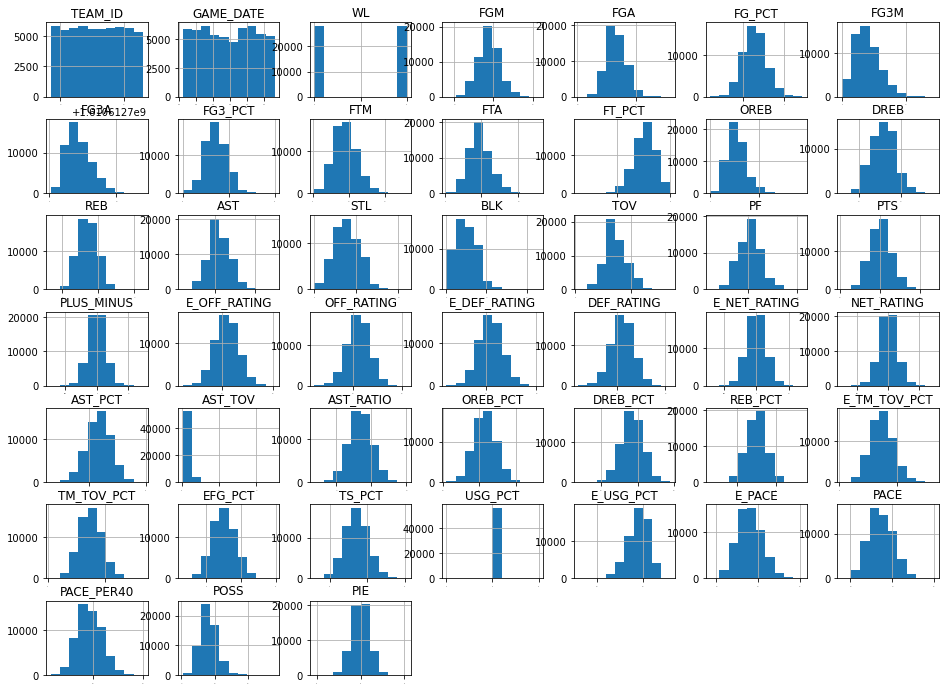

In [16]:
#check distribution of data
team_boxscores_temp_df.hist(figsize=(16,12), xlabelsize=0)

In [17]:
#turn each row's stats into average of last n games
n = 10
non_metric_cols = set(['SEASON', 'TEAM_ID_HOME', 'GAME_ID', 'GAME_DATE', 'TEAM_CITY_HOME', 'TEAM_ID_AWAY','TEAM_CITY_AWAY', 'SPREAD'])
metric_cols = set(team_boxscores_df.columns) - non_metric_cols

moving_average_df = pd.DataFrame(columns=team_boxscores_df.columns)

for i, row in tqdm(team_boxscores_df.iterrows()):
    game_date = row['GAME_DATE']
    home_team = row['TEAM_ID_HOME']
    away_team = row['TEAM_ID_AWAY']
    
    #team_boxscores_historic_df = team_boxscores_temp_df[team_boxscores_temp_df['GAME_DATE'] < game_date].copy()
    
    #if len(team_boxscores_historic_df)==0:
    #    continue
    
    home_team_temp_df = team_boxscores_temp_df[(team_boxscores_temp_df['TEAM_ID']==home_team) &
                                               (team_boxscores_temp_df['GAME_DATE']<game_date)].copy()
    away_team_temp_df = team_boxscores_temp_df[(team_boxscores_temp_df['TEAM_ID']==away_team) &
                                               (team_boxscores_temp_df['GAME_DATE']<game_date)].copy()
    
    if len(home_team_temp_df)<n or len(away_team_temp_df)<n:
        continue
    
    home_team_temp_df.sort_values(by='GAME_DATE', ascending=False, inplace=True)
    away_team_temp_df.sort_values(by='GAME_DATE', ascending=False, inplace=True)
    
    home_team_temp_df = home_team_temp_df.iloc[:n].copy()
    away_team_temp_df = away_team_temp_df.iloc[:n].copy()
    
    new_row = defaultdict()
    for col in team_boxscores_df.columns:
        if col in non_metric_cols:
            new_row[col] = row[col]
        elif col[-4:]=='HOME':
            new_row[col] = home_team_temp_df[col[:-5]].mean()
        elif col[-4:]=='AWAY':
            new_row[col] = away_team_temp_df[col[:-5]].mean()
    moving_average_df = moving_average_df.append(new_row, ignore_index=True)


28152it [34:51, 13.46it/s] 


In [18]:
moving_average_df.head()

,SEASON,TEAM_ID_HOME,GAME_ID,GAME_DATE,WL_HOME,FGM_HOME,FGA_HOME,FG_PCT_HOME,FG3M_HOME,FG3A_HOME,FG3_PCT_HOME,FTM_HOME,FTA_HOME,FT_PCT_HOME,OREB_HOME,DREB_HOME,REB_HOME,AST_HOME,STL_HOME,BLK_HOME,TOV_HOME,PF_HOME,PTS_HOME,PLUS_MINUS_HOME,TEAM_CITY_HOME,E_OFF_RATING_HOME,OFF_RATING_HOME,E_DEF_RATING_HOME,DEF_RATING_HOME,E_NET_RATING_HOME,NET_RATING_HOME,AST_PCT_HOME,AST_TOV_HOME,AST_RATIO_HOME,OREB_PCT_HOME,DREB_PCT_HOME,REB_PCT_HOME,E_TM_TOV_PCT_HOME,TM_TOV_PCT_HOME,EFG_PCT_HOME,TS_PCT_HOME,USG_PCT_HOME,E_USG_PCT_HOME,E_PACE_HOME,PACE_HOME,PACE_PER40_HOME,POSS_HOME,PIE_HOME,TEAM_ID_AWAY,WL_AWAY,FGM_AWAY,FGA_AWAY,FG_PCT_AWAY,FG3M_AWAY,FG3A_AWAY,FG3_PCT_AWAY,FTM_AWAY,FTA_AWAY,FT_PCT_AWAY,OREB_AWAY,DREB_AWAY,REB_AWAY,AST_AWAY,STL_AWAY,BLK_AWAY,TOV_AWAY,PF_AWAY,PTS_AWAY,PLUS_MINUS_AWAY,TEAM_CITY_AWAY,E_OFF_RATING_AWAY,OFF_RATING_AWAY,E_DEF_RATING_AWAY,DEF_RATING_AWAY,E_NET_RATING_AWAY,NET_RATING_AWAY,AST_PCT_AWAY,AST_TOV_AWAY,AST_RATIO_AWAY,OREB_PCT_AWAY,DREB_PCT_AWAY,REB_PCT_AWAY,E_TM_TOV_PCT_AWAY,TM_TOV_PCT_AWAY,EFG_PCT_AWAY,TS_PCT_AWAY,USG_PCT_AWAY,E_USG_PCT_AWAY,E_PACE_AWAY,PACE_AWAY,PACE_PER40_AWAY,POSS_AWAY,PIE_AWAY,SPREAD
0,2021-22,1610612738,0042100404,2022-06-10,0.6,36.0,79.3,0.4536,13.2,35.1,0.3702,20.7,25.8,0.7992,8.9,35.4,44.3,24.5,6.0,6.8,15.1,20.1,105.9,4.6,Boston,109.44,111.61,103.61,106.57,5.82,5.02,0.6819,1.761,18.78,0.2821,0.7234,0.5143,15.5532,15.88,0.5362,0.5842,1.0,0.1989,97.260,94.95,79.125,95.0,0.5479,1610612744,0.6,40.7,85.3,0.4792,14.2,36.7,0.3873,14.0,18.2,0.7678,10.2,35.1,45.3,26.4,6.4,4.5,14.7,20.5,109.6,0.9,Golden State,112.35,113.53,110.81,112.80,1.54,0.73,0.6473,1.967,19.61,0.2750,0.7674,0.5315,14.9613,15.16,0.5622,0.5885,1.0,0.1977,97.990,96.55,80.458,96.7,0.5169,-10
1,2021-22,1610612738,0042100403,2022-06-08,0.6,35.4,79.2,0.4473,14.1,37.1,0.3731,20.3,25.2,0.8006,8.2,36.2,44.4,24.6,5.8,6.8,15.3,20.3,105.2,5.8,Boston,108.12,110.41,101.33,103.95,6.79,6.44,0.6952,1.735,18.86,0.2595,0.7187,0.5032,15.6840,16.03,0.5351,0.5827,1.0,0.1983,97.700,95.50,79.583,95.4,0.5488,1610612744,0.7,40.7,86.5,0.4730,13.6,36.4,0.3741,14.7,18.9,0.7720,10.6,37.0,47.6,26.7,6.3,4.7,14.6,19.7,109.7,2.8,Golden State,111.45,112.60,108.17,110.01,3.28,2.59,0.6556,1.994,19.61,0.2810,0.7858,0.5426,14.6971,14.89,0.5514,0.5801,1.0,0.1979,98.896,97.50,81.250,97.7,0.5292,16
2,2021-22,1610612744,0042100402,2022-06-05,0.7,42.1,86.4,0.4901,13.8,35.9,0.3867,15.2,19.0,0.7925,10.4,36.8,47.2,27.6,5.3,4.9,15.0,20.4,113.2,3.9,Golden State,114.20,115.36,109.95,112.01,4.24,3.35,0.6557,1.999,20.07,0.2859,0.7860,0.5512,15.0126,15.20,0.5697,0.5990,1.0,0.1975,99.456,98.00,81.667,98.3,0.5336,1610612738,0.7,36.2,79.9,0.4535,14.3,37.7,0.3721,20.5,25.8,0.7893,8.4,35.9,44.3,24.4,5.8,6.8,14.2,20.2,107.2,9.0,Boston,110.48,112.80,100.22,102.92,10.26,9.86,0.6731,1.884,18.75,0.2579,0.7166,0.5014,14.6168,14.93,0.5416,0.5880,1.0,0.1984,97.488,95.25,79.375,95.1,0.5658,19
3,2021-22,1610612744,0042100401,2022-06-02,0.7,42.2,87.1,0.4879,12.6,35.2,0.3629,15.5,19.3,0.7970,10.6,37.9,48.5,27.9,5.1,4.5,15.4,20.8,112.5,4.6,Golden State,112.47,113.68,108.08,109.50,4.38,4.17,0.6617,1.978,20.09,0.2857,0.7889,0.5537,15.2468,15.46,0.5604,0.5910,1.0,0.1972,100.182,98.90,82.417,99.2,0.5401,1610612738,0.6,36.1,79.6,0.4541,13.2,36.7,0.3532,20.5,25.7,0.7947,8.2,35.8,44.0,23.6,5.7,6.9,13.9,20.8,105.9,7.5,Boston,109.67,111.41,100.35,103.13,9.32,8.25,0.6559,1.880,18.38,0.2448,0.7101,0.4931,14.3592,14.61,0.5360,0.5832,1.0,0.1987,97.298,95.25,79.375,95.1,0.5597,-12
4,2021-22,1610612748,0042100307,2022-05-29,0.5,36.8,85.0,0.4344,10.1,33.9,0.3011,17.1,20.9,0.8035,10.6,29.8,40.4,20.5,8.9,4.1,13.0,21.1,100.8,-1.7,Miami,104.08,107.29,107.64,109.54,-3.56,-2.24,0.5602,1.663,15.97,0.3044,0.7419,0.5071,13.4758,13.90,0.4940,0.5358,1.0,0.1971,95.958,93.60,77.999,93.7,0.4723,1610612738,0.6,36.8,79.5,0.4629,13.5,37.2,0.3566,20.4,25.3,0.8055,7.6,35.1,42.7,23.9,5.5,6.7,13.7,20.7,107.5,7.9,Boston,111.14,112.94,101.61,104.25,9.55,8.66,0.6525,1.938,18.63,0.2352,0.7005,0.4869,14.1424,14.39,0.5467,0.5934,1.0

In [19]:
moving_average_df.describe()

,WL_HOME,FGM_HOME,FGA_HOME,FG_PCT_HOME,FG3M_HOME,FG3A_HOME,FG3_PCT_HOME,FTM_HOME,FTA_HOME,FT_PCT_HOME,OREB_HOME,DREB_HOME,REB_HOME,AST_HOME,STL_HOME,BLK_HOME,TOV_HOME,PF_HOME,PTS_HOME,PLUS_MINUS_HOME,E_OFF_RATING_HOME,OFF_RATING_HOME,E_DEF_RATING_HOME,DEF_RATING_HOME,E_NET_RATING_HOME,NET_RATING_HOME,AST_PCT_HOME,AST_TOV_HOME,AST_RATIO_HOME,OREB_PCT_HOME,DREB_PCT_HOME,REB_PCT_HOME,E_TM_TOV_PCT_HOME,TM_TOV_PCT_HOME,EFG_PCT_HOME,TS_PCT_HOME,USG_PCT_HOME,E_USG_PCT_HOME,E_PACE_HOME,PACE_HOME,PACE_PER40_HOME,POSS_HOME,PIE_HOME,WL_AWAY,FGM_AWAY,FGA_AWAY,FG_PCT_AWAY,FG3M_AWAY,FG3A_AWAY,FG3_PCT_AWAY,FTM_AWAY,FTA_AWAY,FT_PCT_AWAY,OREB_AWAY,DREB_AWAY,REB_AWAY,AST_AWAY,STL_AWAY,BLK_AWAY,TOV_AWAY,PF_AWAY,PTS_AWAY,PLUS_MINUS_AWAY,E_OFF_RATING_AWAY,OFF_RATING_AWAY,E_DEF_RATING_AWAY,DEF_RATING_AWAY,E_NET_RATING_AWAY,NET_RATING_AWAY,AST_PCT_AWAY,AST_TOV_AWAY,AST_RATIO_AWAY,OREB_PCT_AWAY,DREB_PCT_AWAY,REB_PCT_AWAY,E_TM_TOV_PCT_AWAY,TM_TOV_PCT_AWAY,EFG_PCT_AWAY,TS_PCT_AWAY,USG_PCT_AWAY,E_USG_PCT_AWAY,E_PACE_AWAY,PACE_AWAY,PACE_PER40_AWAY,POSS_AWAY,PIE_AWAY
count,27990.000000,27990.000000,27990.000000,27990.000000,27990.000000,27990.000000,27990.000000,27990.000000,27990.000000,27990.000000,27990.000000,27990.000000,27990.000000,27990.000000,27990.000000,27990.000000,27990.000000,27990.000000,27990.000000,27990.000000,27990.000000,27990.000000,27990.000000,27990.000000,27990.000000,27990.000000,27990.000000,27990.000000,27990.000000,27990.000000,27990.000000,27990.000000,27990.000000,27990.000000,27990.000000,27990.000000,27990.0,27990.000000,27990.000000,27990.000000,27990.000000,27990.000000,27990.000000,27990.000000,27990.000000,27990.000000,27990.000000,27990.000000,27990.000000,27990.000000,27990.000000,27990.000000,27990.000000,27990.000000,27990.000000,27990.000000,27990.000000,27990.000000,27990.000000,27990.000000,27990.000000,27990.000000,27990.000000,27990.000000,27990.000000,27990.000000,27990.000000,27990.000000,27990.000000,27990.000000,27990.000000,27990.00000,27990.000000,27990.000000,27990.000000,27990.000000,27990.000000,27990.000000,27990.000000,27990.0,27990.000000,27990.000000,27990.000000,27990.000000,27990.000000,27990.000000
mean,0.498214,37.572626,82.851833,0.454380,7.729128,21.686906,0.353078,18.125320,23.873758,0.759838,10.956631,31.657231,42.613862,22.062183,7.559310,4.881986,14.352662,20.964519,100.999700,-0.061951,104.376369,105.989614,104.435389,106.054481,-0.058953,-0.064871,0.586288,1.683896,16.898714,0.288715,0.710813,0.499749,14.830838,15.069203,0.500731,0.541657,1.0,0.198499,96.046528,94.543625,78.786352,95.237656,0.499503,0.502519,37.611969,82.914591,0.454486,7.731633,21.679171,0.353141,18.154848,23.915559,0.759827,10.995927,31.693919,42.689846,22.102519,7.567163,4.896949,14.347513,20.954602,101.110418,0.087081,104.451149,106.070025,104.367283,105.979380,0.083795,0.090646,0.586771,1.687888,16.91475,0.289480,0.711049,0.500299,14.819097,15.058180,0.500820,0.541766,1.0,0.198497,96.081653,94.578474,78.815385,95.269064,0.500642
std,0.206321,2.893347,4.594552,0.023456,3.050945,8.009461,0.039875,2.712274,3.496970,0.043080,1.812468,2.745069,2.889766,2.697464,1.236402,1.126965,1.677721,2.171738,7.950903,5.997735,5.553047,5.552607,5.311908,5.313600,6.544425,6.237519,0.051614,0.325243,1.589607,0.036660,0.031520,0.020539,1.760291,1.795290,0.032593,0.029637,0.0,0.000813,4.219821,4.078874,3.399055,4.133371,0.043882,0.205737,2.913810,4.581741,0.023521,3.057411,8.005131,0.039566,2.711504,3.497892,0.042718,1.821762,2.741681,2.891710,2.717116,1.240750,1.128529,1.683415,2.166817,7.974338,5.989188,5.584858,5.582646,5.326178,5.323652,6.529230,6.226273,0.051902,0.329367,1.60271,0.036623,0.031437,0.020471,1.755928,1.792663,0.032715,0.029695,0.0,0.000821,4.208762,4.072609,3.393827,4.126763,0.043807
min,0.000000,27.000000,68.700000,0.366500,1.200000,5.500000,0.147200,8.300000,12.000000,0.562900,4.800000,23.000000,32.400000,13.900000,3.700000,1.200000,8.300000,13.900000,74.800000,-22.800000,79.320000,82.120000,82.240000,83.230000,-24.

In [20]:
def check_missing_vals(df):
    cols_w_missing_vals = []
    for col in df.columns:
        if df[col].isna().sum() != 0:
            cols_w_missing_vals.append(col)
    return cols_w_missing_vals

In [21]:
check_missing_vals(moving_average_df)

[]

In [22]:
moving_average_df.to_csv('moving_average_df_10.csv')

In [23]:
#turn each row's stats into weighted average of last n games
n = 10
non_metric_cols = set(['SEASON', 'TEAM_ID_HOME', 'GAME_ID', 'GAME_DATE', 'TEAM_CITY_HOME', 'TEAM_ID_AWAY','TEAM_CITY_AWAY', 'SPREAD'])
metric_cols = set(team_boxscores_df.columns) - non_metric_cols

weights = np.linspace(1.5, 0.5, n)
weighted_average_df = pd.DataFrame(columns=team_boxscores_df.columns)

for i, row in tqdm(team_boxscores_df.iterrows()):
    game_date = row['GAME_DATE']
    home_team = row['TEAM_ID_HOME']
    away_team = row['TEAM_ID_AWAY']
    
    home_team_temp_df = team_boxscores_temp_df[(team_boxscores_temp_df['TEAM_ID']==home_team) &
                                               (team_boxscores_temp_df['GAME_DATE']<game_date)].copy()
    away_team_temp_df = team_boxscores_temp_df[(team_boxscores_temp_df['TEAM_ID']==away_team) &
                                               (team_boxscores_temp_df['GAME_DATE']<game_date)].copy()
    
    if len(home_team_temp_df)<n or len(away_team_temp_df)<n:
        continue
    
    home_team_temp_df.sort_values(by='GAME_DATE', ascending=False, inplace=True)
    away_team_temp_df.sort_values(by='GAME_DATE', ascending=False, inplace=True)
    
    home_team_temp_df = home_team_temp_df.iloc[:n].copy()
    away_team_temp_df = away_team_temp_df.iloc[:n].copy()
    
    new_row = defaultdict()
    for col in team_boxscores_df.columns:
        if col in non_metric_cols:
            new_row[col] = row[col]
        elif col[-4:]=='HOME':
            new_row[col] = np.average(home_team_temp_df[col[:-5]], weights=weights)
            #new_row[col] = home_team_temp_df[col[:-5]].mean()
        elif col[-4:]=='AWAY':
            new_row[col] = np.average(away_team_temp_df[col[:-5]], weights=weights)
            #new_row[col] = away_team_temp_df[col[:-5]].mean()
    weighted_average_df = weighted_average_df.append(new_row, ignore_index=True)

weighted_average_df.head()

28152it [35:51, 13.09it/s] 


,SEASON,TEAM_ID_HOME,GAME_ID,GAME_DATE,WL_HOME,FGM_HOME,FGA_HOME,FG_PCT_HOME,FG3M_HOME,FG3A_HOME,FG3_PCT_HOME,FTM_HOME,FTA_HOME,FT_PCT_HOME,OREB_HOME,DREB_HOME,REB_HOME,AST_HOME,STL_HOME,BLK_HOME,TOV_HOME,PF_HOME,PTS_HOME,PLUS_MINUS_HOME,TEAM_CITY_HOME,E_OFF_RATING_HOME,OFF_RATING_HOME,E_DEF_RATING_HOME,DEF_RATING_HOME,E_NET_RATING_HOME,NET_RATING_HOME,AST_PCT_HOME,AST_TOV_HOME,AST_RATIO_HOME,OREB_PCT_HOME,DREB_PCT_HOME,REB_PCT_HOME,E_TM_TOV_PCT_HOME,TM_TOV_PCT_HOME,EFG_PCT_HOME,TS_PCT_HOME,USG_PCT_HOME,E_USG_PCT_HOME,E_PACE_HOME,PACE_HOME,PACE_PER40_HOME,POSS_HOME,PIE_HOME,TEAM_ID_AWAY,WL_AWAY,FGM_AWAY,FGA_AWAY,FG_PCT_AWAY,FG3M_AWAY,FG3A_AWAY,FG3_PCT_AWAY,FTM_AWAY,FTA_AWAY,FT_PCT_AWAY,OREB_AWAY,DREB_AWAY,REB_AWAY,AST_AWAY,STL_AWAY,BLK_AWAY,TOV_AWAY,PF_AWAY,PTS_AWAY,PLUS_MINUS_AWAY,TEAM_CITY_AWAY,E_OFF_RATING_AWAY,OFF_RATING_AWAY,E_DEF_RATING_AWAY,DEF_RATING_AWAY,E_NET_RATING_AWAY,NET_RATING_AWAY,AST_PCT_AWAY,AST_TOV_AWAY,AST_RATIO_AWAY,OREB_PCT_AWAY,DREB_PCT_AWAY,REB_PCT_AWAY,E_TM_TOV_PCT_AWAY,TM_TOV_PCT_AWAY,EFG_PCT_AWAY,TS_PCT_AWAY,USG_PCT_AWAY,E_USG_PCT_AWAY,E_PACE_AWAY,PACE_AWAY,PACE_PER40_AWAY,POSS_AWAY,PIE_AWAY,SPREAD
0,2021-22,1610612738,0042100404,2022-06-10,0.633333,36.155556,80.183333,0.450311,13.411111,35.250000,0.374644,19.605556,24.588889,0.792700,9.050000,35.422222,44.472222,24.983333,6.000000,6.700000,14.994444,19.694444,105.327778,4.355556,Boston,108.756667,110.991667,103.338333,106.268333,5.407778,4.710000,0.692817,1.788944,19.035556,0.284083,0.729744,0.516183,15.433244,15.760000,0.533433,0.578733,1.0,0.198994,97.293111,94.963889,79.136611,95.033333,0.545761,1610612744,0.566667,40.427778,84.783333,0.478089,14.300000,36.683333,0.389550,14.366667,18.477778,0.780578,9.755556,33.927778,43.683333,26.477778,7.100000,4.194444,14.038889,20.205556,109.522222,1.127778,Golden State,112.918333,114.208333,111.130556,113.320000,1.785556,0.892778,0.652872,2.042722,19.787222,0.271500,0.762733,0.525017,14.408939,14.614444,0.562356,0.590150,1.0,0.197917,97.430111,95.875000,79.895778,95.994444,0.515328,-10
1,2021-22,1610612738,0042100403,2022-06-08,0.588889,35.077778,79.055556,0.443894,13.883333,36.261111,0.376006,19.816667,24.488889,0.803533,8.022222,36.200000,44.222222,24.644444,5.788889,6.677778,15.438889,20.138889,103.855556,3.688889,Boston,106.912222,109.226111,102.088333,104.977222,4.817222,4.233333,0.702900,1.712722,18.928889,0.258794,0.717772,0.501889,15.845889,16.199444,0.530683,0.578117,1.0,0.198461,97.644222,95.288889,79.407278,95.233333,0.540756,1610612744,0.683333,40.950000,86.194444,0.476900,13.911111,36.166667,0.384317,14.827778,19.183333,0.771656,10.422222,36.000000,46.422222,27.116667,6.983333,4.238889,13.733333,19.527778,110.638889,3.955556,Golden State,113.329444,114.535556,108.778333,110.891667,4.548889,3.648333,0.661056,2.131444,19.988333,0.283944,0.791422,0.544400,13.963428,14.152778,0.557422,0.585672,1.0,0.197872,98.095333,96.577778,80.481556,96.794444,0.534133,16
2,2021-22,1610612744,0042100402,2022-06-05,0.650000,41.838889,86.200000,0.487672,13.855556,35.850000,0.387183,15.155556,19.111111,0.789906,10.833333,36.011111,46.844444,27.755556,5.516667,4.638889,14.222222,20.177778,112.688889,2.705556,Golden State,115.287778,116.171111,111.953889,114.137222,3.326667,2.038333,0.662728,2.124389,20.286111,0.292728,0.792167,0.552878,14.431411,14.584444,0.567728,0.596911,1.0,0.197439,98.181556,96.827778,80.690056,97.172222,0.528244,1610612738,0.705556,36.077778,79.316667,0.455028,13.883333,36.572222,0.371961,20.727778,25.700000,0.801839,8.366667,35.961111,44.327778,24.611111,5.877778,6.655556,14.477778,20.344444,106.766667,8.044444,Boston,110.372222,112.711111,100.992222,103.756667,9.373333,8.936667,0.680206,1.840000,18.925000,0.262383,0.710356,0.501900,14.953956,15.275000,0.541278,0.589622,1.0,0.198656,97.211556,94.941667,79.118056,94.794444,0.566011,19
3,2021-22,1610612744,0042100401,2022-06-02,0.727778,42.233333,86.372222,0.491806,12.677778,34.488889,0.371361,15.772222,19.705556,0.798767,10.755556,37.650000,48.4

In [24]:
weighted_average_df.describe()

,WL_HOME,FGM_HOME,FGA_HOME,FG_PCT_HOME,FG3M_HOME,FG3A_HOME,FG3_PCT_HOME,FTM_HOME,FTA_HOME,FT_PCT_HOME,OREB_HOME,DREB_HOME,REB_HOME,AST_HOME,STL_HOME,BLK_HOME,TOV_HOME,PF_HOME,PTS_HOME,PLUS_MINUS_HOME,E_OFF_RATING_HOME,OFF_RATING_HOME,E_DEF_RATING_HOME,DEF_RATING_HOME,E_NET_RATING_HOME,NET_RATING_HOME,AST_PCT_HOME,AST_TOV_HOME,AST_RATIO_HOME,OREB_PCT_HOME,DREB_PCT_HOME,REB_PCT_HOME,E_TM_TOV_PCT_HOME,TM_TOV_PCT_HOME,EFG_PCT_HOME,TS_PCT_HOME,USG_PCT_HOME,E_USG_PCT_HOME,E_PACE_HOME,PACE_HOME,PACE_PER40_HOME,POSS_HOME,PIE_HOME,WL_AWAY,FGM_AWAY,FGA_AWAY,FG_PCT_AWAY,FG3M_AWAY,FG3A_AWAY,FG3_PCT_AWAY,FTM_AWAY,FTA_AWAY,FT_PCT_AWAY,OREB_AWAY,DREB_AWAY,REB_AWAY,AST_AWAY,STL_AWAY,BLK_AWAY,TOV_AWAY,PF_AWAY,PTS_AWAY,PLUS_MINUS_AWAY,E_OFF_RATING_AWAY,OFF_RATING_AWAY,E_DEF_RATING_AWAY,DEF_RATING_AWAY,E_NET_RATING_AWAY,NET_RATING_AWAY,AST_PCT_AWAY,AST_TOV_AWAY,AST_RATIO_AWAY,OREB_PCT_AWAY,DREB_PCT_AWAY,REB_PCT_AWAY,E_TM_TOV_PCT_AWAY,TM_TOV_PCT_AWAY,EFG_PCT_AWAY,TS_PCT_AWAY,USG_PCT_AWAY,E_USG_PCT_AWAY,E_PACE_AWAY,PACE_AWAY,PACE_PER40_AWAY,POSS_AWAY,PIE_AWAY
count,27990.000000,27990.000000,27990.000000,27990.000000,27990.000000,27990.000000,27990.000000,27990.000000,27990.000000,27990.000000,27990.000000,27990.000000,27990.000000,27990.000000,27990.000000,27990.000000,27990.000000,27990.000000,27990.000000,27990.000000,27990.000000,27990.000000,27990.000000,27990.000000,27990.000000,27990.000000,27990.000000,27990.000000,27990.000000,27990.000000,27990.000000,27990.000000,27990.000000,27990.000000,27990.000000,27990.000000,27990.0,27990.000000,27990.000000,27990.000000,27990.000000,27990.000000,27990.000000,27990.000000,27990.000000,27990.000000,27990.000000,27990.000000,27990.000000,27990.000000,27990.000000,27990.000000,27990.000000,27990.000000,27990.000000,27990.000000,27990.000000,27990.000000,27990.000000,27990.000000,27990.000000,27990.000000,27990.000000,27990.000000,27990.000000,27990.000000,27990.000000,27990.000000,27990.000000,27990.000000,27990.000000,27990.000000,27990.000000,27990.000000,27990.000000,27990.000000,27990.000000,27990.000000,27990.000000,27990.0,27990.000000,27990.000000,27990.000000,27990.000000,27990.000000,27990.000000
mean,0.497732,37.570138,82.853635,0.454340,7.732448,21.699329,0.353026,18.122035,23.870116,0.759845,10.955316,31.656867,42.612183,22.061055,7.556864,4.881506,14.352917,20.966161,100.994760,-0.077226,104.369872,105.983485,104.445810,106.064802,-0.075845,-0.081345,0.586297,1.683630,16.898076,0.288670,0.710802,0.499708,14.830655,15.069198,0.500711,0.541631,1.0,0.198497,96.048366,94.545303,78.787750,95.238818,0.499388,0.502917,37.619830,82.919500,0.454554,7.736103,21.687767,0.353217,18.157046,23.916163,0.759873,10.995242,31.697085,42.692327,22.107227,7.568999,4.896415,14.344364,20.949674,101.132810,0.100159,104.470709,106.089558,104.372148,105.984769,0.098460,0.104814,0.586770,1.688705,16.917288,0.289485,0.711105,0.500340,14.815641,15.054509,0.500911,0.541854,1.0,0.198498,96.084633,94.581390,78.817816,95.272182,0.500744
std,0.211820,2.937724,4.650921,0.024117,3.067811,8.035332,0.041410,2.780038,3.574491,0.044231,1.853743,2.796956,2.961477,2.745638,1.268919,1.154485,1.720096,2.216607,8.041120,6.139500,5.663010,5.660686,5.422020,5.421690,6.696969,6.385599,0.052639,0.332359,1.624191,0.037353,0.032402,0.021103,1.798848,1.834807,0.033223,0.030243,0.0,0.000846,4.252179,4.111939,3.426608,4.175777,0.044929,0.211428,2.956168,4.637865,0.024147,3.073162,8.022022,0.041219,2.782056,3.579168,0.043851,1.862891,2.789931,2.965249,2.759556,1.274143,1.156582,1.727235,2.205040,8.063956,6.135656,5.694274,5.688597,5.455911,5.450147,6.689695,6.381225,0.052840,0.337667,1.631397,0.037388,0.032325,0.021113,1.797809,1.835279,0.033316,0.030276,0.0,0.000852,4.234624,4.098034,3.415014,4.160750,0.044856
min,0.000000,27.050000,68.194444,0.366406,1.233333,5.272222,0.147061,7.861111,11.377778,0.562089,4.611111,22.488889,32.400000,14.044444,3.522222,1.200000,8.016667,13.666667,74.633333,-22.483333,79.044444,81.720000,82.827222,83.760000,-

In [25]:
weighted_average_df.to_csv('weighted_average_df_10.csv')

In [26]:
#to do:
#correct col dtypes
#plot metric distributions and check for anamolies
#check for correlations (may need to minimize multi-colinearity in order to utilize some models)
#train and eval baseline model

In [27]:
#turn each row's stats into weighted average of last n game stats

#instead of taking average of all metrics, it may be better to recalculate some of the agg metrics (e.g FB_PCT, AST_TOV, etc.)
#over last n games